# ✈️ Travel Planner

## 📥 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## 📝 Problem Definition
This notebook provides an analysis of the `costs.csv` and `evaluation_results.csv`, obtained through our testing framework.

As our tests were conducted using the **Llama 3.1 8B** model, we will base our analysis on the average pricing across cloud platforms, as shown in the model pricing below or on [this link](https://www.llama.com/llama3_1/).

On average, the input cost is approximately **$0.31 per 1 million tokens**, while the output cost is around **$0.36 per 1 million tokens**.

<img src="model_pricing.png" alt="Llama 3.1 Model Pricing" width="600">


In [2]:
PRICING = {
    'input_cost_per_1m': 0.31,
    'output_cost_per_1m': 0.36
}

## Data

### Data loading

Then we will load our two datasets :
- `costs.csv` corresponds to the token consumption for each step (flight/hotel/activity search, ...) when a user prompt is received by the agent
- `evaluation_results.csv` represents a batch of tests made with the [test_agent.py](../tests/test_agent.py) file and using the following [prompts](../tests/prompts.csv)

In [3]:
df_costs = pd.read_csv('../costs.csv')
df_results = pd.read_csv('../tests/evaluation_results.csv')
print("Files loaded successfully.")

Files loaded successfully.


### Data Preprocessing and Aggregation

In [4]:
# 2.1 Aggregate costs per scenario
# We need to sum up all API calls for a single user request to get the total cost/latency for that request.
cost_summary = df_costs.groupby('scenario_id').agg({
    'call_id': 'count',                 # Total API calls made
    'prompt_tokens': 'sum',
    'completion_tokens': 'sum',
    'total_tokens': 'sum',
    'latency_ms': 'sum',                # Total time taken
    'status': lambda x: (x == 'SUCCESS').mean()  # Success rate of internal calls
}).reset_index()

In [5]:
# Rename columns for clarity
cost_summary.rename(columns={'call_id': 'num_api_calls', 'status': 'internal_success_rate'}, inplace=True)

In [6]:
# 2.2 Merge with Evaluation Results
# Merge the cost data with the judge's scores based on the ID
df_final = pd.merge(df_results, cost_summary, left_on='id', right_on='scenario_id')

In [7]:
# 2.3 Define Architecture Labels
# Map the boolean flags to the specific configuration names from your report
def get_architecture_label(row):
    if row['use_planner'] and row['use_tools'] and row['use_reasoning']:
        return 'Planner + Tools + Reasoning'
    elif row['use_planner'] and row['use_tools']:
        return 'Planner + Tools'
    elif row['use_planner']:
        return 'Planner Only'
    else:
        return 'Baseline'
    
df_final['architecture'] = df_final.apply(get_architecture_label, axis=1)

In [8]:
# 2.4 Calculate Estimated Financial Cost
df_final['estimated_cost_usd'] = (
    (df_final['prompt_tokens'] / 1_000_000 * PRICING['input_cost_per_1m']) +
    (df_final['completion_tokens'] / 1_000_000 * PRICING['output_cost_per_1m'])
)

In [9]:
print(f"Data processed. Total Scenarios: {len(df_final)}")
display(df_final.head())

Data processed. Total Scenarios: 54


,id,conditions,analysis,relevance,helpfulness,logic,use_reasoning,use_planner,use_tools,scenario_id,num_api_calls,prompt_tokens,completion_tokens,total_tokens,latency_ms,internal_success_rate,architecture,estimated_cost_usd
0,9f0bfa74-60d2-4e1c-b7e7-4f9539a41553,Should identify reasonable flight options from...,The AI's response is weak in terms of helpfuln...,10,2,5,0,1,1,9f0bfa74-60d2-4e1c-b7e7-4f9539a41553,4,1346,379,1725,36138.58,1.0,Planner + Tools,0.000554
1,0cbb028e-a379-469c-b1da-3566b5de265d,Should identify flights from London to the Mal...,The AI's response is weak in terms of helpfuln...,10,2,5,0,1,1,0cbb028e-a379-469c-b1da-3566b5de265d,4,1328,311,1639,32121.71,1.0,Planner + Tools,0.000524
2,8cba4d7d-a3de-451b-96bb-9918cd72a328,Should propose a logical travel route through ...,The AI response provides a detailed itinerary ...,9,8,9,0,1,1,8cba4d7d-a3de-451b-96bb-9918cd72a328,7,4102,1134,5236,112899.28,1.0,Planner + Tools,0.001680
3,0b6353ea-3f78-4b94-8ecd-8ae611dc6083,Should identify business-class flight options ...,The AI response correctly identifies the user'...,9,7,8,0,1,1,0b6353ea-3f78-4b94-8ecd-8ae611dc6083,7,3389,1009,4398,114119.06,1.0,Planner + Tools,0.001414
4,1f82b2b1-c004-4b88-83b8-a0047e50fdc3,Should suggest suitable accommodation for four...,The AI's response is weak in terms of relevanc...,2,1,10,0,1,1,1f82b2b1-c004-4b88-83b8-a0047e50fdc3,4,1310,273,1583,37257.43,1.0,Planner + Tools,0.000504


## Analysis

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_26820/2615118345.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='architecture', y='total_tokens', data=df_final, palette="Blues")


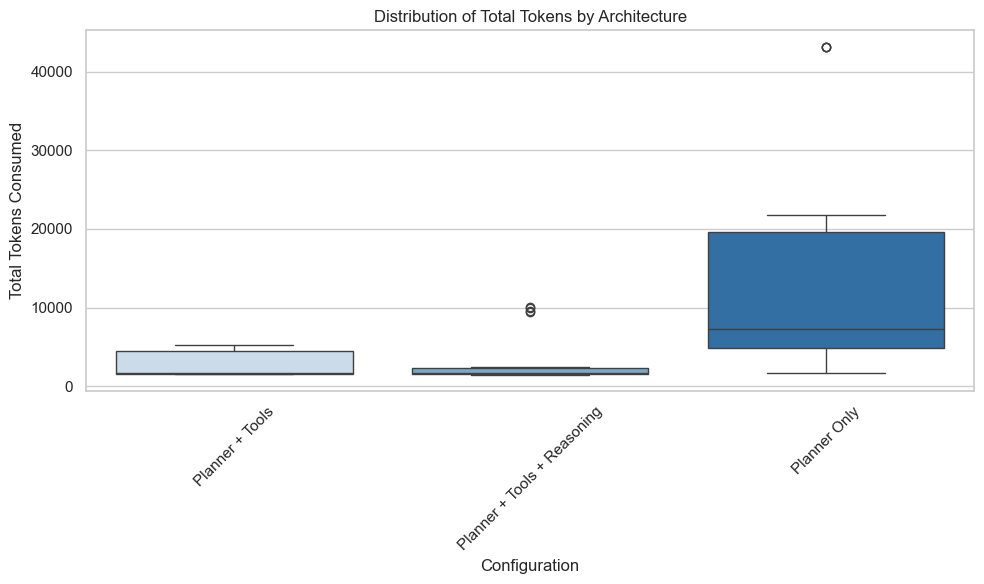

In [10]:
# Figure 1: Cost Analysis (Token Consumption)
plt.figure(figsize=(10, 6))
sns.boxplot(x='architecture', y='total_tokens', data=df_final, palette="Blues")
plt.title('Distribution of Total Tokens by Architecture')
plt.ylabel('Total Tokens Consumed')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_26820/1557864623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='architecture', y='helpfulness', data=df_final, palette="Greens")


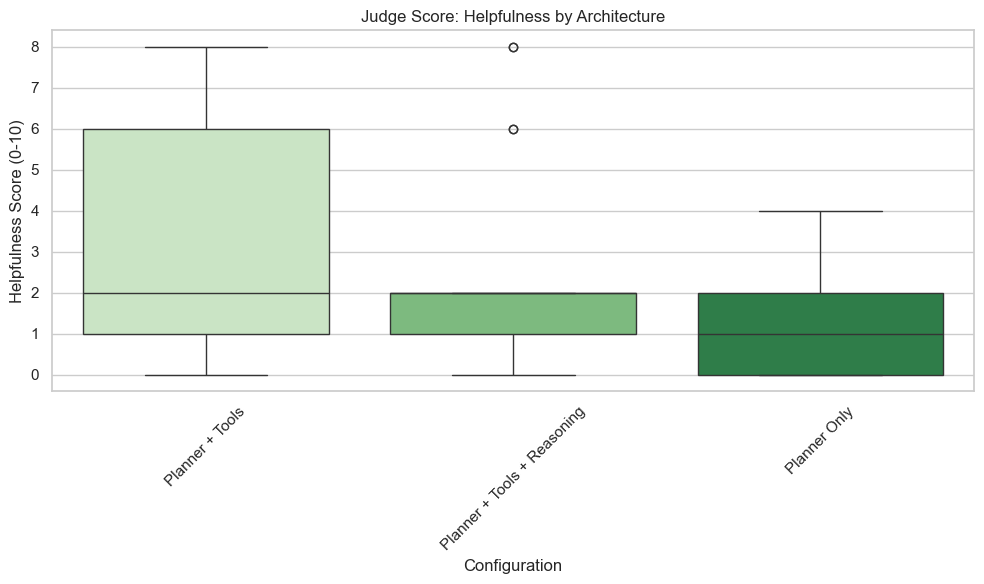

In [11]:
# Figure 2: Quality Analysis (Helpfulness Score)
plt.figure(figsize=(10, 6))
sns.boxplot(x='architecture', y='helpfulness', data=df_final, palette="Greens")
plt.title('Judge Score: Helpfulness by Architecture')
plt.ylabel('Helpfulness Score (0-10)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/pg/1l4d75p90r565jztmcw4v8c00000gn/T/ipykernel_26820/2757414983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='architecture', y='latency_ms', data=df_final, palette="Oranges", errorbar='sd')


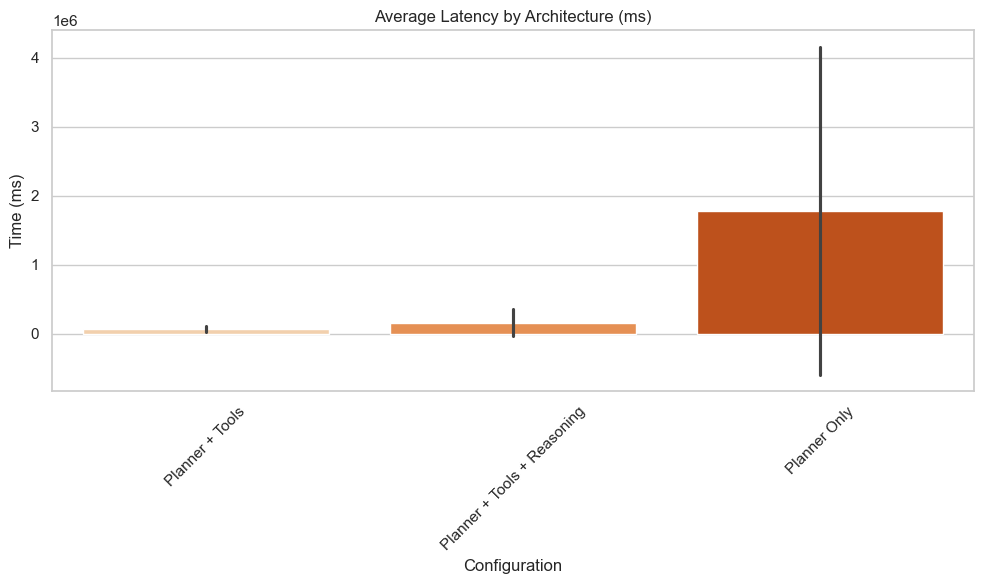

In [12]:
# Figure 3: Latency Analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='architecture', y='latency_ms', data=df_final, palette="Oranges", errorbar='sd')
plt.title('Average Latency by Architecture (ms)')
plt.ylabel('Time (ms)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Efficiency metrics

In [13]:
# Calculate "Tokens per Score Point"
# Lower is better: It means you spent fewer tokens to get a high score.
# We add a small epsilon (0.1) to avoid division by zero.
df_final['efficiency_ratio'] = df_final['total_tokens'] / (df_final['helpfulness'] + 0.1)

print("\n--- PERFORMANCE SUMMARY TABLE ---")
summary_table = df_final.groupby('architecture').agg({
    'total_tokens': 'mean',
    'latency_ms': 'mean',
    'helpfulness': 'mean',
    'logic': 'mean',
    'efficiency_ratio': 'mean'
}).round(2)
# Sort by Helpfulness to see the best performing one
summary_table.sort_values('helpfulness', ascending=False)


--- PERFORMANCE SUMMARY TABLE ---


,total_tokens,latency_ms,helpfulness,logic,efficiency_ratio
architecture,,,,,
Planner + Tools,2703.95,68945.97,3.35,7.65,1671.49
Planner + Tools + Reasoning,3325.90,162084.88,2.60,7.50,1849.15
Planner Only,15413.36,1780155.16,1.21,8.57,23857.96


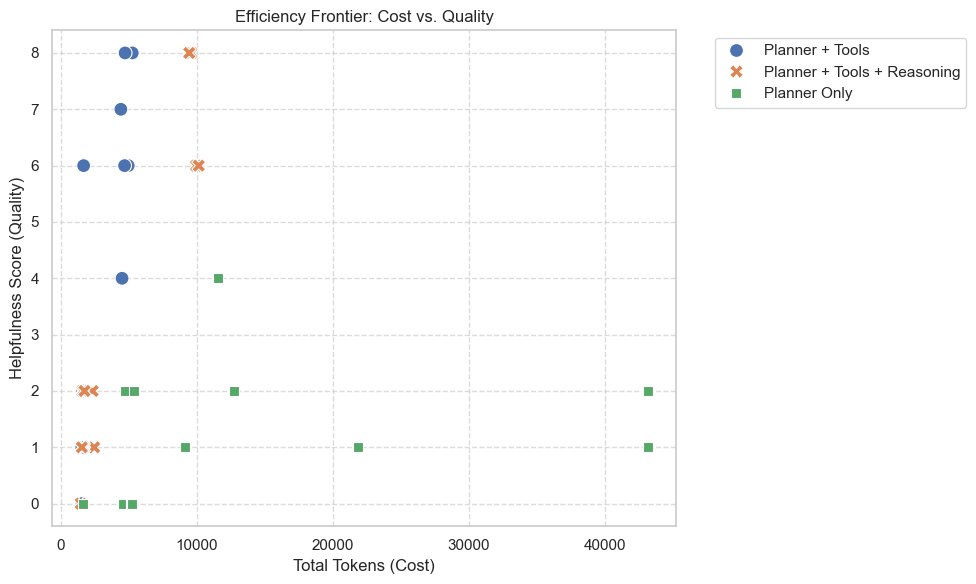

In [14]:
# Figure 4: Efficiency Scatter Plot (Pareto Frontier)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_final, 
    x='total_tokens', 
    y='helpfulness', 
    hue='architecture', 
    style='architecture', 
    s=100
)
plt.title('Efficiency Frontier: Cost vs. Quality')
plt.xlabel('Total Tokens (Cost)')
plt.ylabel('Helpfulness Score (Quality)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()